In [5]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [27]:
class f_rosenbrock():

  def f(x):
    return ((1 - x[0])**2) + (100 * (x[1] - (x[0]**2))**2)

  def grad(x):
    return np.array([
        -2 * (1 - x[0]) - 4 * 100 * (x[1] - x[0]**2) * x[0],
        2 * 100 * (x[1] - x[0]**2)
    ])

  def hess(x):
    return np.matrix([
        [1200 * x[0]**2 - 400 * x[1] + 2, -400 * x[0]],
        [-400 * x[0], 200]
    ])

class f_himmelblau():

  def f(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

  def grad(x):
    return np.array([
          2 * (x[0]**2 + x[1] - 11) * (2 * x[0]) + 2 * (x[0] + x[1]**2 - 7),
          2 * (x[0]**2 + x[1] - 11) + 2 * (x[0] + x[1] **2 - 7) * (2 * x[1])
      ])

  def hess(x):
    return np.matrix([
      [8 * x[0]**2 + 4 * (x[0]**2 + x[1] - 11) + 2, 4 * x[0] + 4 * x[1]],
      [4 * x[0] + 4 * x[1], 8 * x[1]**2 + 4 * (x[1]**2 + x[0] - 7) + 2]
    ])

class f_rastrigin():

  def f(x):
    return 20 + (x[0]**2 - 10 * np.cos(2 * np.pi * x[0])) + (x[1]**2 - 10 * np.cos(2 * np.pi * x[1]))

  def grad(x):
    return np.array([
          2 * x[0] + 20 * np.pi * np.sin(2 * np.pi * x[0]),
          2 * x[1] + 20 * np.pi * np.sin(2 * np.pi * x[1])
      ])

  def hess(x):
    return np.matrix([
      [40 * np.pi**2 * np.cos(2 * np.pi * x[0]) + 2, 0],
      [0, 40 * np.pi**2 * np.cos(2 * np.pi * x[1]) + 2]
    ])

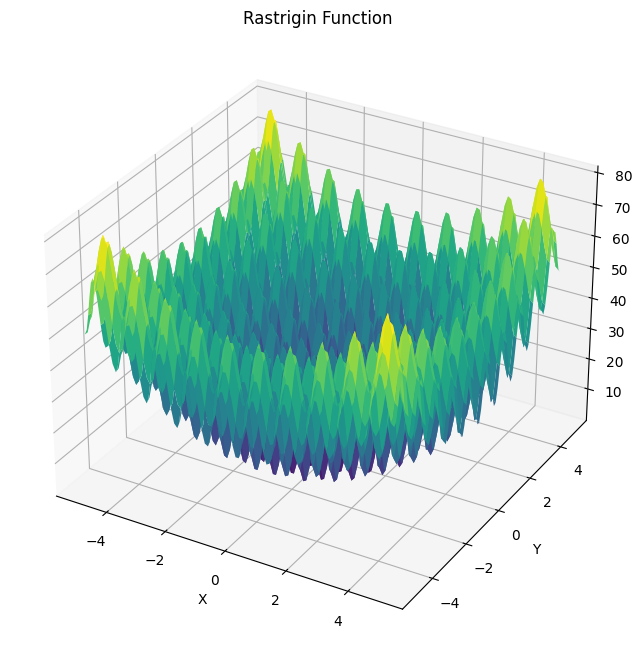

In [23]:
# Создание сетки точек для отображения функций
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Визуализация функции Rastrigin
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f_rastrigin.f(np.array([X, Y])), cmap='viridis')
ax.set_title('Rastrigin Function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [17]:
def grad_step(lr_func):

  def grad_inner(f, x = None, maxiter = 1000, tol = 1e-18):
    if x is None:
        x = np.random.random(2)

    for iter in range(1, maxiter+1):
        grad = f.grad(x)
        lr = lr_func(f.f, x, -grad)
        if np.linalg.norm(lr * grad) < tol:
            return x, iter
        x -= lr * grad

    return x, maxiter

  return grad_inner

def newton(lr_func):

  def newton_inner(f, x = None, maxiter = 1000, tol = 1e-18):
    if x is None:
        x = np.random.random(2)

    prev_x = np.copy(x)
    for iter in range(1, maxiter+1):
      hess = f.hess(x)
      grad = f.grad(x)
      p = np.linalg.solve(hess, -grad)
      lr = lr_func(f.f, x, p)
      x += lr * p

      if np.linalg.norm(x - prev_x) < tol:
        return x, iter
      prev_x = np.copy(x)

    return x, maxiter

  return newton_inner

def fixed_search(f, x, d, tol = None):
    return 1

def dichotomy_search(f, x, d, tol=1e-6):
    a, b = -1, 1

    while abs(b - a) > tol:
        c = (a + b) / 2
        x1, x2 = x + (c - tol) * d, x + (c + tol) * d
        f1, f2 = f(x1), f(x2)

        if f1 < f2:
            b = c
        else:
            a = c

    return (a + b) / 2

def golden_section_search(f, x, d, tol=1e-6):
    a, b = 0, 1
    rho = (np.sqrt(5) - 1) / 2

    while abs(b - a) > tol:
        x1 = a + (1 - rho) * (b - a)
        x2 = a + rho * (b - a)

        f1 = f(x + x1 * d)
        f2 = f(x + x2 * d)

        if f1 < f2:
            b = x2
        else:
            a = x1

    return (a + b) / 2

def Nelder_Mead_search(f, curr_x, num_iter = 1000):
    history = []
    def callback_func(x):
        history.append(np.copy(x))
    res = minimize(f, curr_x, method='Nelder-Mead', options={'disp': True, 'maxiter' : num_iter}, callback=callback_func)
    return res.nit, history, res.x

def minimize_wrapper(method, options = {}, jac = None):

  def inner(f, x0 = None, maxiter = 1000, tol = 1e-18):
    if x0 is None:
      x0 = np.random.random(2)

    options['maxiter'] = maxiter

    _jac = jac
    if _jac is None:
      _jac = f.grad
    res = minimize(f.f, x0, method=method, jac=_jac, hess=f.hess, tol=tol, options=options)
    return res.x, res.nit

  return inner

In [18]:
class method_class:
  def __init__(self, name, f):
      self.name = name
      self.f = f

newton_fixed = method_class("Ньютон с фиксированным шагом", newton(fixed_search))
newton_dichotomy = method_class("Ньютон с дихотомией", newton(dichotomy_search))
newton_cg = method_class("Newton-CG", minimize_wrapper('Newton-CG'))

nelder_mead = method_class("Neldear-Mead", minimize_wrapper('Nelder-Mead'))
grad_golden = method_class("Градиентный спуск с золотым сечением", grad_step(golden_section_search))

bfgs = method_class("BFGS", minimize_wrapper('BFGS', options = {'norm': 2}))
lbfgs = method_class("L-BFGS-B", minimize_wrapper('L-BFGS-B'))
bfgs_diff = method_class("BFGS, производная через разностые схемы", minimize_wrapper('BFGS', options = {'norm': 2}, jac = '3 step'))
lbfgs_diff = method_class("L-BFGS-B, производная через разностые схемы", minimize_wrapper('L-BFGS-B', jac = '3 step'))

In [3]:
class method_result:

  def __init__(self):
    self.history = []
    self.fev = 0
    self.jacev = 0
    self.hessev = 0

class f_wrapper:

  def __init__(self, inner_f):
    self.inner_f = inner_f
    self.result = method_result()

  def record(self, x):
    self.result.history.append(np.around(x, 5))

  def f(self, x):
    self.record(x)
    self.result.fev += 1
    return self.inner_f.f(x)

  def grad(self, x):
    self.record(x)
    self.result.jacev += 1
    return self.inner_f.grad(x)

  def hess(self, x):
    self.record(x)
    self.result.hessev += 1
    return self.inner_f.hess(x)

def record_calc(inner_f, to_run):
  f = f_wrapper(inner_f)
  return to_run(f), f.result

def analyze(f, x0, method):
  return record_calc(f, lambda fu: method(fu, x0))

# record_calc(f_rosenbrock, lambda f: newton(f, fixed_search))
# record_calc(f_rosenbrock, lambda f: newton(f, dichotomy_search))
# newton_cg(f_rosenbrock)
# res, his = record_calc(f_rosenbrock, lambda f: newton_cg(f))
# print(res)
# print(len(his))
# analyze(f_spherical, None, newton(fixed_search))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


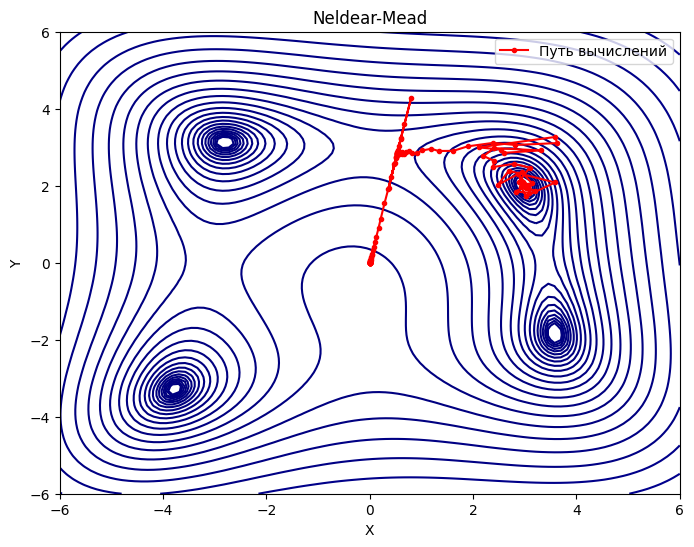

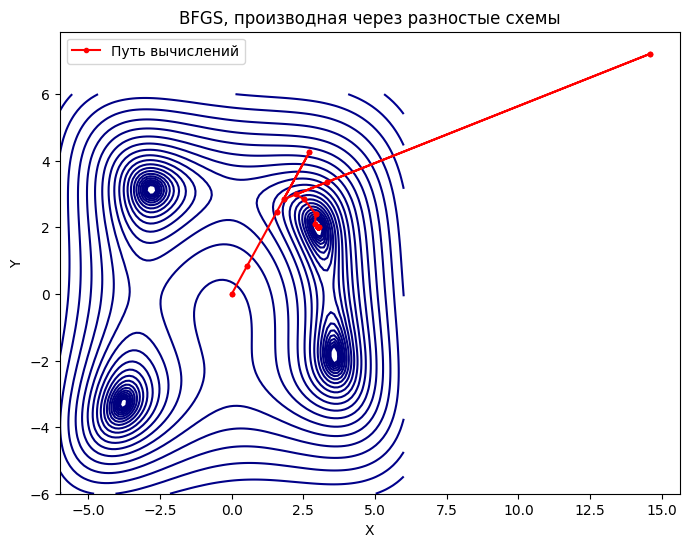

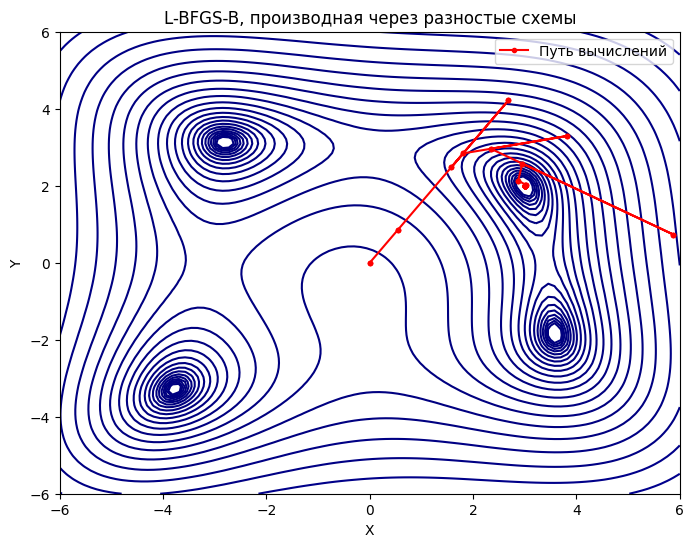

In [31]:
def method_2d(f, x0, method, method_name):
    (x_star, iter), res = analyze(f, x0, method)
    history = np.array(res.history)
    x = np.linspace(-6, 6, 100)
    y = np.linspace(-6, 6, 100)
    X, Y = np.meshgrid(x, y)
    Z = f.f(np.array([X, Y]))
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), cmap='jet')
    ax.plot(history[:, 0], history[:, 1], marker='o', color='red', markersize=3, label='Путь вычислений')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(method_name + ": итераций: " + str(iter) + ", min: " \
                 + str(np.round(x_star, 5)) + ", " + str(round(f.f(x_star), 5)) \
                 + ", вычислений функции в точке: " + str(res.fev) \
                 + ", вычислений градиента: " + str(res.jacev) \
                 + ", вычислений гессиана: " + str(res.hessev))
    ax.set_title(method_name)
    ax.legend()

def all_method_2d(f, x0):
  # for method in [newton_fixed, newton_dichotomy, newton_cg, bfgs, lbfgs]:
  # for method in [bfgs, bfgs_diff, lbfgs, lbfgs_diff]:
  for method in [nelder_mead, bfgs_diff, lbfgs_diff]:
    method_2d(f, np.copy(x0), method.f, method.name)

all_method_2d(f_himmelblau, np.array([0.0, 0.0]))
# all_method_2d(f_himmelblau, np.array([-0.27084, -0.92304]))
# print(analyze(f_himmelblau, np.array([0.0, 0.0]), newton(fixed_search)))
# print(analyze(f_himmelblau, np.array([0.0, 0.0]), newton(dichotomy_search)))
